In [1]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16100945244805419966, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16349765515548462235
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16756230224545828630
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13317108965002934940
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
import os
os.chdir('/content/gdrive/My Drive/ADetector')

from ADdatagen import AnomalyDataGen

data_path = '/content/gdrive/My Drive/ADetector/data'
win_size = 10
batch_size = 1
img_in_shape = [227, 227, 1]
in_shape = (None, win_size, img_in_shape[0], img_in_shape[1], img_in_shape[2])
epochs = 1
gen_test = AnomalyDataGen(data_path=data_path, win_size=win_size,
                          batch_size=batch_size,
                          shuffle=False, img_input_shape=tuple(img_in_shape),
                          aug_steps=[1], train=False)
gen_train = AnomalyDataGen(data_path=data_path, win_size=win_size,
                          batch_size=batch_size,
                          shuffle=True, img_input_shape=tuple(img_in_shape),
                          aug_steps=[1, 2, 3, 4], train=True)

In [5]:
from model import ModelADetector
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-4, decay=1e-5, epsilon=1e-6)
model = ModelADetector()
model.build(input_shape=in_shape)
model.compile(loss='mse', optimizer=opt)

In [6]:
model.summary()

Model: "model_a_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri multiple                  15616     
_________________________________________________________________
layer_normalization (LayerNo multiple                  256       
_________________________________________________________________
time_distributed_1 (TimeDist multiple                  204864    
_________________________________________________________________
layer_normalization_1 (Layer multiple                  128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    multiple                  295168    
_________________________________________________________________
layer_normalization_2 (Layer multiple                  128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  multiple             

In [ ]:
#model.fit(gen_train, epochs=epochs)
#model.save_weights('/content/gdrive/My Drive/ADetector/ADettector.h5')

In [7]:
model.load_weights('/content/gdrive/My Drive/ADetector/ADettector.h5')

In [8]:
batch_size = 190
gen_test = AnomalyDataGen(data_path=data_path, win_size=win_size,
                          batch_size=batch_size,
                          shuffle=False, img_input_shape=tuple(img_in_shape),
                          aug_steps=[1], train=False)
gen_train = AnomalyDataGen(data_path=data_path, win_size=win_size,
                          batch_size=batch_size,
                          shuffle=False, img_input_shape=tuple(img_in_shape),
                          aug_steps=[1], train=True)

In [9]:
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

X = gen_test.__getitem__(26)
Y = model.predict(X)
LOSS = []
for y, x in zip(Y, X):
  img_x, img_y = x[-1], y[-1]
  loss = np.linalg.norm(np.subtract(img_x, img_y))
  LOSS.append(loss)

min, max = np.min(LOSS), np.max(LOSS)
abnormal_score = (LOSS - min)/max
regularity_score_a = 1 - abnormal_score

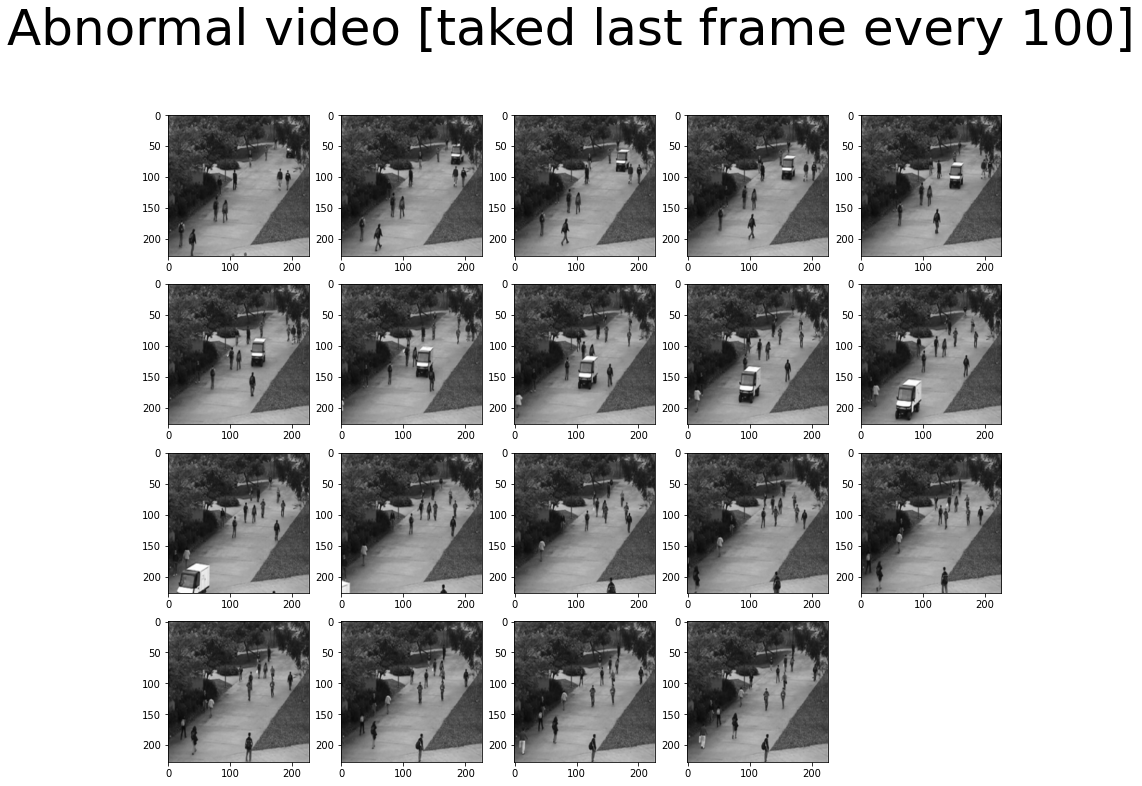

In [10]:
import matplotlib.pyplot as plt
import cv2

inds = np.arange(0, 190, 10)
figure = plt.figure(figsize=(15, 15))
figure.suptitle('Abnormal video [taked last frame every 100]', fontsize=50)
for i, idx in enumerate(inds):
  img = X[idx][-1]
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  plt.subplot(5, 5, i + 1)
  plt.imshow(img)
figure.savefig('/content/gdrive/My Drive/ADetector/Abnormal_sample.png')

In [11]:
X = gen_train.__getitem__(1)[0]
Y = model.predict(X)
LOSS = []
for y, x in zip(Y, X):
  img_x, img_y = x[-1], y[-1]
  loss = np.linalg.norm(np.subtract(img_x, img_y))
  LOSS.append(loss)

min, max = np.min(LOSS), np.max(LOSS)
abnormal_score = (LOSS - min)/max
regularity_score_n = 1 - abnormal_score

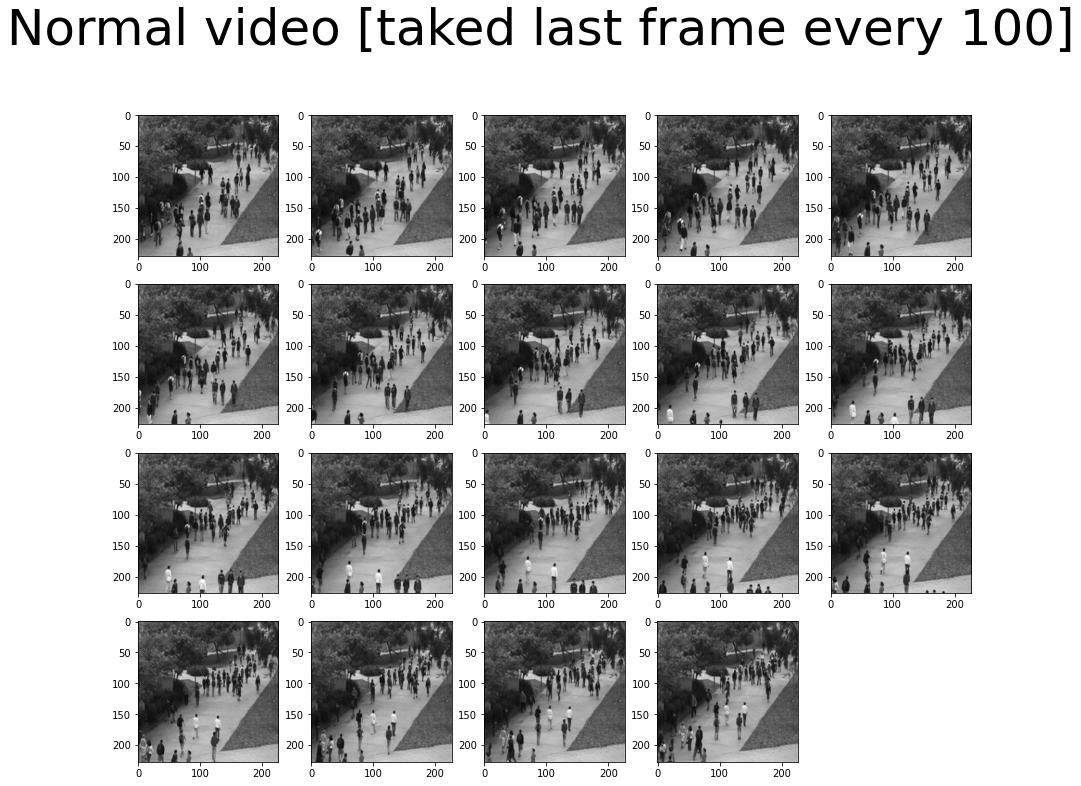

In [12]:
inds = np.arange(0, 190, 10)
figure = plt.figure(figsize=(15, 15))
figure.suptitle('Normal video [taked last frame every 100]', fontsize=50)
for i, idx in enumerate(inds):
  img = X[idx][-1]
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  plt.subplot(5, 5, i + 1)
  plt.imshow(img)
figure.savefig('/content/gdrive/My Drive/ADetector/Normal_sample.png')

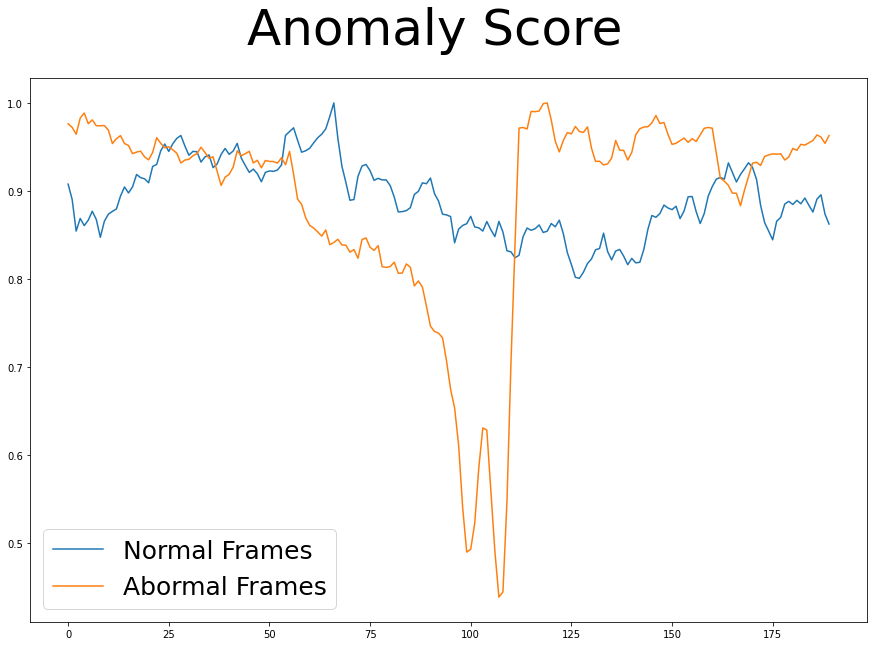

In [13]:

figure = plt.figure(figsize=(15, 10))
figure.suptitle('Anomaly Score', fontsize=50)
plt.plot(regularity_score_n, label='Normal Frames')
plt.plot(regularity_score_a, label='Abormal Frames')
plt.legend(fontsize=25)
figure.savefig('/content/gdrive/My Drive/ADetector/AS.png')